In [1]:
import torch
from PIL import Image
import open_clip
import numpy as np
import pandas as pd
from sklearn.metrics import top_k_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

/home/ezraf/miniconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Torch device: ', device)

Torch device:  cuda


In [3]:
base_model = 'RN50'
model, _, preprocess = open_clip.create_model_and_transforms(base_model, pretrained=f'./logs/{base_model}_RS_FineTuned_50epochs/checkpoints/epoch_50.pt')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer(base_model)

/home/ezraf/miniconda3/envs/clip/lib/python3.11/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path

In [4]:
randomseed = 420

In [5]:
test_data = pd.read_csv('../datasets/NWPU-Captions/test.csv', sep='\t')
test_data_onedesc = test_data.groupby('filepath', as_index=False).sample(1, random_state=randomseed).reset_index(drop=True)
classes = test_data.groupby('class', as_index=False).sample(1, random_state=randomseed).reset_index(drop=True)['class'].values

In [6]:
seeds = [120, 42, 720, 360, 42346, 8834, 54234, 122, 768, 3]
test_captions = []
for s in seeds:
    test_captions.append(test_data.groupby('class', as_index=False).sample(1, random_state=s).reset_index(drop=True)['caption'].values)

In [7]:
images = []
for i, row in test_data_onedesc.iterrows():
    images.append(Image.open(row['filepath']))
proc_images = []
for img in images:
    proc_images.append(preprocess(img))
image_input = torch.tensor(np.stack(proc_images), dtype=torch.float)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
image_features /= image_features.norm(dim=-1, keepdim=True)

similarities = []
for captions in test_captions:
    text_tokens = tokenizer(captions)

    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()

    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities.append(text_features.cpu().numpy() @ image_features.cpu().numpy().T)

In [8]:
similarity = np.stack(similarities).mean(axis=0)
true_class = test_data_onedesc['class'].values
le = LabelEncoder()
le.fit(classes)
y_true= le.transform(true_class)

# le_desc = LabelEncoder
# le.fit(test_data_onedesc['caption'].values)
# y_desc_true = le.transform(test_data_onedesc['caption'].values)

In [9]:
top_k_stats = []
# Class-wise
top_k_stats.append({'k': 1, 'score': top_k_accuracy_score(y_true, similarity.T, k=1)})
top_k_stats.append({'k': 3, 'score': top_k_accuracy_score(y_true, similarity.T, k=3)})
top_k_stats.append({'k': 5, 'score': top_k_accuracy_score(y_true, similarity.T, k=5)})
top_k_stats.append({'k': 10, 'score': top_k_accuracy_score(y_true, similarity.T, k=10)})
top_k_stats.append({'k': 20, 'score': top_k_accuracy_score(y_true, similarity.T, k=20)})
top_k_stats.append({'k': 30, 'score': top_k_accuracy_score(y_true, similarity.T, k=30)})

In [10]:
top_k_stats

[{'k': 1, 'score': np.float64(0.9552380952380952)},
 {'k': 3, 'score': np.float64(0.9838095238095238)},
 {'k': 5, 'score': np.float64(0.9911111111111112)},
 {'k': 10, 'score': np.float64(0.9974603174603175)},
 {'k': 20, 'score': np.float64(0.9996825396825397)},
 {'k': 30, 'score': np.float64(0.9996825396825397)}]

In [11]:
pred_class = []
for sim in similarity.T:
    pred_class.append(classes[np.argmax(sim)])

In [12]:
avg_correct_cos = 0
for i, sim in enumerate(similarity.T):
    avg_correct_cos += sim[y_true[i]]

avg_correct_cos /= len(similarity.T)
avg_correct_cos

np.float32(0.70670056)

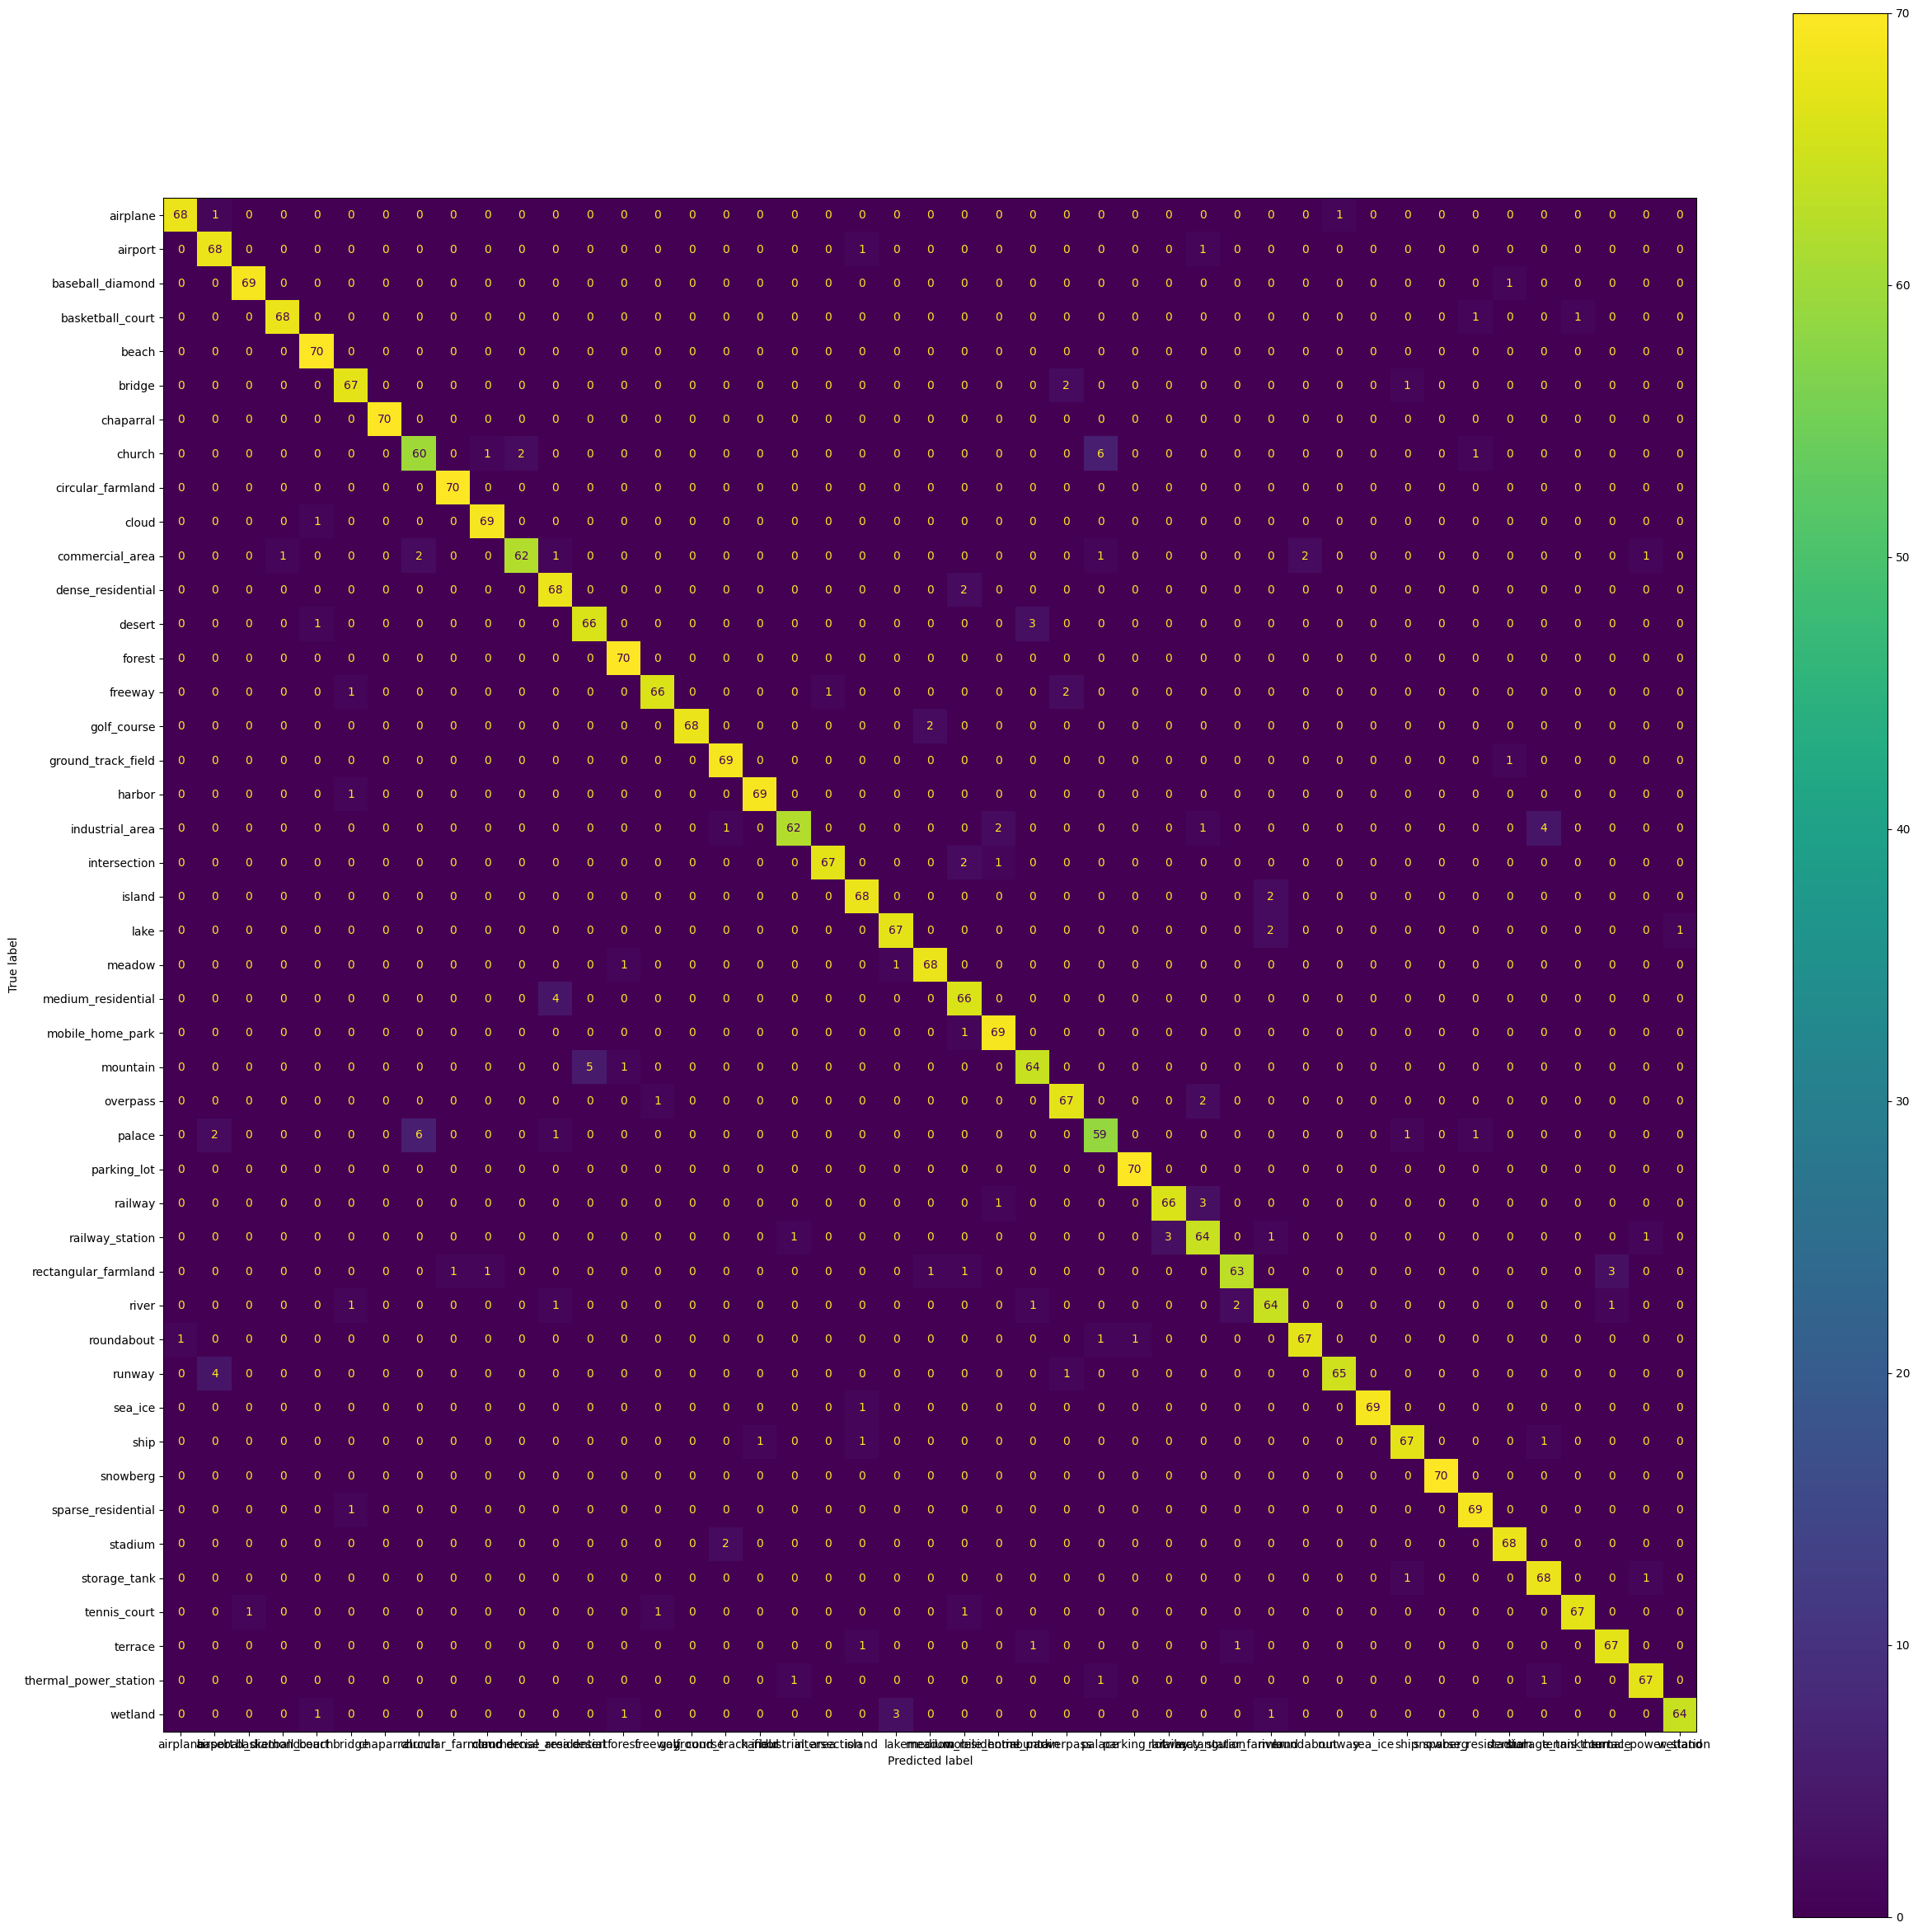

In [13]:
cm = confusion_matrix(true_class, pred_class)
# Create a DataFrame for better visualization
# df_cm = pd.DataFrame(cm, index=classes, columns=classes)

# # Plot the confusion matrix using seaborn
# plt.figure(figsize=(10, 7))
# sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes, )
fig, ax = plt.subplots(figsize=(30,30))
cm_display.plot(ax=ax)
plt.show()

In [14]:
np.stack(similarities).mean(axis=0).shape

(45, 3150)

In [15]:
test_data_onedesc.groupby('class').count()

,filepath,caption
class,,
airplane,70,70
airport,70,70
baseball_diamond,70,70
basketball_court,70,70
beach,70,70
bridge,70,70
chaparral,70,70
church,70,70
circular_farmland,70,70
